# Working on efficient SRHT without large matrix storing

In [1]:
import numpy as np
from numpy.testing import assert_array_almost_equal 
import scipy
from scipy import sparse
from sklearn.utils.extmath import safe_sparse_dot
import warnings
warnings.filterwarnings("always")

from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

## Sparse matrices tools

In [3]:
def csr_row_set_nz_to_val(M, row, value=0):
    """Set all nonzero elements of a CSR matrix M (elements currently in the sparsity pattern)
    to the given value. Useful to set to 0 mostly.
    https://stackoverflow.com/a/12130287/9978618
    """
    if not isinstance(M, scipy.sparse.csr_matrix):
        raise ValueError("Matrix given must be of CSR format.")
    if value == 0:
        M.data = np.delete(M.data, range(M.indptr[row], M.indptr[row+1])) # drop nnz values
        M.indices = np.delete(M.indices, range(M.indptr[row], M.indptr[row+1])) # drop nnz column indices
        M.indptr[(row+1):] = M.indptr[(row+1):] - (M.indptr[row+1] - M.indptr[row])
    else:
        M.data[M.indptr[row]:M.indptr[row+1]] = value # replace nnz values by another nnz value

def lil_set_row_to_zero(M, row):
    """Set the row of a LIL matrix M to zero."""
    if not isinstance(M, sparse.lil_matrix):
        raise ValueError("Matrix given must be of LIL format.")
    M.data[row] = []
    M.rows[row] = []

def lil_row_set_nz_to_val(M, row, value=0):
    """Set all nonzero elements of a LIL matrix M (elements currently in the sparsity pattern)
    to the given value. Useful to set to 0 mostly.
    """
    if not isinstance(M, sparse.lil_matrix):
        raise ValueError("Matrix given must be of LIL format.")
    if value == 0:
        M.data[row] = []
        M.rows[row] = []
    else:
        M.data[row] = value

In [4]:
# Checking that csr_row_set_nz_to_val function is correct
A = scipy.sparse.csr_matrix([[0,1,0], [2,0,3], [0,0,0], [4,0,0]])
print("Initial CSR matrix A :\n", A.toarray(), "\n")
csr_row_set_nz_to_val(A, 0)
print("Setting nnz values of first row to 0 :\n", A.toarray(), "\n")
csr_row_set_nz_to_val(A, 1, value=7)
print("Setting nnz values of second row to 7 :\n", A.toarray())

Initial CSR matrix A :
 [[0 1 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 

Setting nnz values of first row to 0 :
 [[0 0 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 

Setting nnz values of second row to 7 :
 [[0 0 0]
 [7 0 7]
 [0 0 0]
 [4 0 0]]


In [5]:
# Apply csr_row_set_nz_to_val to rows full of zeros
A = scipy.sparse.csr_matrix([[0,1,0], [2,0,3], [0,0,0], [4,0,0]])
print("Initial CSR matrix A :\n", A.toarray(), "\n")
csr_row_set_nz_to_val(A, 2)
print("Setting nnz values of first row to 0 :\n", A.toarray())

Initial CSR matrix A :
 [[0 1 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 

Setting nnz values of first row to 0 :
 [[0 1 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]]


In [6]:
# Checking that lil_set_row_to_zero function is correct
A = scipy.sparse.lil_matrix([[0,1,0], [2,0,3], [0,0,0], [4,0,0]])
print("Initial LIL matrix A :\n", A.toarray(), "\n")
lil_set_row_to_zero(A, 0)
print("Setting nnz values of first row to 0 :\n", A.toarray(), "\n")
lil_set_row_to_zero(A, 1)
print("Setting nnz values of second row to 0 :\n", A.toarray())

Initial LIL matrix A :
 [[0 1 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 

Setting nnz values of first row to 0 :
 [[0 0 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 

Setting nnz values of second row to 0 :
 [[0 0 0]
 [0 0 0]
 [0 0 0]
 [4 0 0]]


In [7]:
# Apply lil_set_row_to_zero to rows full of zeros
A = scipy.sparse.lil_matrix([[0,1,0], [2,0,3], [0,0,0], [4,0,0]])
print("Initial LIL matrix A :\n", A.toarray(), "\n")
lil_set_row_to_zero(A, 2)
print("Setting nnz values of first row to 0 :\n", A.toarray(), "\n")

Initial LIL matrix A :
 [[0 1 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 

Setting nnz values of first row to 0 :
 [[0 1 0]
 [2 0 3]
 [0 0 0]
 [4 0 0]] 



## FWHT: Fast Walsh-Hadamard Transform (wikipedia implementation)

In [32]:
def fwht(a):
    """Fast Walsh–Hadamard Transform of array a.
    No normalization factor.
    """
    if not np.log2(len(a)).is_integer():
        raise ValueError("size of the sequence must be a power of 2")
    b = a.copy()
    h = 1
    while h < len(b):
        for i in range(0, len(b), h * 2):
            for j in range(i, i + h):
                x = b[j]
                y = b[j + h]
                b[j] = x + y
                b[j + h] = x - y
        h *= 2
    return b

# def fwht_matrix(M):
#     """Fast Walsh–Hadamard Transform of each column of matrix M.

#     Equivalent to the multiplication on the left of M by the Hadamard matrix of order M.shape[0].
#     No normalization factor"""
#     return np.apply_along_axis(fwht, 0, M) # doesn't work on scipy.sparse data

def fwht_matrix(M, verbose=False):
    """Fast Walsh–Hadamard Transform of each column of matrix M (sparse or dense).

    Equivalent to the multiplication on the left of M by the Hadamard matrix of order M.shape[0].
    No normalization factor.
    """
    if verbose:
        print("------ Debug ------")

    if not np.log2(M.shape[0]).is_integer():
        raise ValueError("Size of the sequence must be a power of 2.")
    
    sparse_matrix = False
    B = M.copy()
    if sparse.issparse(M):
        sparse_matrix = True
        if not isinstance(M, sparse.lil_matrix):
            # warnings.warn("Matrix is converted to CSR format.")
            # B = B.asformat("csr")
            warnings.warn("Matrix is converted to LIL format.")
            B = B.asformat("lil")

    h = 1
    while h < B.shape[0]:
        for i in range(0, B.shape[0], h * 2):
            for j in range(i, i + h):
                # if b.shape[1]:
                #     x = b[j]
                #     y = b[j + h]
                #     b[j] = x + y
                #     b[j + h] = x - y
                if verbose:
                    print("------ j:", j, " / h:", h)
                    print("Before update:   B[j, :] =", B[j, :], " | B[j+h, :] =", B[j+h, :])
                x = B[j, :].copy()         # I guess B should be CSR
                y = B[j + h, :].copy()
                if verbose:
                    print("After x+y & x-y: B[j, :] =", B[j, :], " | B[j+h, :] =", B[j+h, :])
                    print("                  x + y  =", x+y, " |   x - y   =", x-y)
                
                if sparse_matrix and (x+y).getnnz() == 0:
                    # csr_row_set_nz_to_val(B, j)
                    lil_row_set_nz_to_val(B, j, value=0)
                else:
                    B[j, :] = x + y
                
                if sparse_matrix and (x-y).getnnz() == 0:
                    # csr_row_set_nz_to_val(B, j+h)
                    lil_row_set_nz_to_val(B, j+h, value=0)
                else:
                    B[j+h, :] = x - y
                
                if verbose:
                    print("After update:    B[j, :] =", B[j, :], " | B[j+h, :] =", B[j+h, :], "\n")
        h *= 2
    return B

### Testing FWHT (no subsampling)

In [42]:
# Testing FWHT on vectors
b = np.array([1, 0, 1, 0, 0, 1, 1, 0])
b_transform = np.array([4, 2, 0, -2, 0, 2, 0, 2]) # ground truth taken from Wikipedia

H = fwht_matrix(np.eye(len(b)))
assert all(b_transform == fwht(b))
assert all(b_transform == H @ b)

In [43]:
print(b.shape)
b_matrix = b.reshape(-1, 1)
print(b_matrix.shape)
print(fwht_matrix(b_matrix).flatten()) # Does not work

print(b_transform)

(8,)
(8, 1)
[ 4  2  0 -2  0  2  0  2]
[ 4  2  0 -2  0  2  0  2]


### Implementing a version of FWTH for sparse vectors/matrices

In [33]:
b_sparse = sparse.csr_matrix(b_matrix)
print(b_sparse.shape)
# b_sparse = b_sparse.reshape(-1, 1)
b_sparse = b_sparse.tocsc()
print(type(b_sparse))
# print(b_sparse.shape)
print(fwht_matrix(b_sparse).toarray().flatten())

print(b_transform)

(8, 1)
<class 'scipy.sparse.csc.csc_matrix'>
[ 4  2  0 -2  0  2  0  2]
[ 4  2  0 -2  0  2  0  2]
/home/nidham/phd/RidgeSketch/ridge_sketch/ridgesketch-env/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matrix is converted to LIL format.


In [34]:
fwht_matrix(b_matrix, verbose=False).flatten()

array([ 4,  2,  0, -2,  0,  2,  0,  2])

In [35]:
fwht_matrix(b_sparse.asformat("csc"), verbose=False).toarray().flatten() 

/home/nidham/phd/RidgeSketch/ridge_sketch/ridgesketch-env/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matrix is converted to LIL format.


array([ 4,  2,  0, -2,  0,  2,  0,  2], dtype=int64)

In [38]:
# Testing FWHT on sparse vectors
# ----------- Debugging -----------
m = 2 ** 3
for i in range(10):
    v = np.random.choice([0, 1], size=(m,), p=[6./10, 4./10])
    v = sparse.lil_matrix(v).reshape(-1, 1)
    assert all(fwht(v.toarray().flatten()) == fwht_matrix(v).toarray().flatten())
# -> fwht and fwht_matrix return same outputs

In [48]:
m = 2 ** 2
I_sparse = sparse.eye(m, format="lil")
print(I_sparse.toarray(), "\n")
print(fwht_matrix(I_sparse).toarray(), "\n")

I = np.eye(m)
print(fwht_matrix(I))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

[[ 1.  1.  1.  1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1.  1.]] 

[[ 1.  1.  1.  1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1.  1.]]


In [56]:
m = 2 ** 2
M = sparse.random(m, m, density=0.2, format="lil")
print(M.toarray(), "\n")
print(fwht_matrix(M).toarray())

[[0.         0.         0.53403748 0.        ]
 [0.         0.         0.85124707 0.        ]
 [0.         0.23892472 0.         0.        ]
 [0.         0.         0.         0.        ]] 

[[ 0.          0.23892472  1.38528455  0.        ]
 [ 0.          0.23892472 -0.31720959  0.        ]
 [ 0.         -0.23892472  1.38528455  0.        ]
 [ 0.         -0.23892472 -0.31720959  0.        ]]


### ---------------------------------

In [57]:
# Testing FWHT on matrices

# Hard-coded Hadamard matrices through Sylvester's construction
# https://en.wikipedia.org/wiki/Hadamard_matrix#Sylvester's_construction
H_true = np.empty(())
for idx in np.arange(3):
    n = 2 ** idx
    if n == 1:
        H_true = np.array([[1]])
    else:
        H_true = np.block([[H_true, H_true], [H_true, -H_true]])
    
    H = fwht_matrix(np.eye(n))
    assert (H_true == H).all()
    # print("Dimension:", n)
    # print(H_true, "\n")

# Applying fwht to a matrix of order m A is equivalent to multiply H_m * A 
# where H_m is the Hadamard matrix of order m
m = 4
A = np.random.randint(5, size=(m, m))
# print("\nA: \n", A, "\n")
assert (fwht_matrix(np.eye(m)) @ A == fwht_matrix(A)).all()

## TWHT: Trimmed Walsh-Hadamard Transform

In [58]:
# Implementing Trimmed Walsh-Hadamard transform O(d * log(k))

# Converting last stage indices (full of NaN and only one 0) to one-hot sparse vectors
# Important assumption: sampling without replacement 
def idx2vec(idx):
    """Converts back an array of indices to a subsampling vector"""
    # Only one 1 and all other entries are zeros if sampling is without replacement
    # row = np.where(idx == 0.)[0]
    # col = np.array([0]) # 1-dimensional vector
    # data = np.array([1])
    
    # TODO: this should be changed to sampling with replacement: potentially two 1 in a single vector
    row = np.where(idx == 0.)[0]
    col = np.zeros(len(row))
    data = np.ones(len(row))

    x = sparse.csr_matrix((data, (row, col)), shape=(len(idx), 1), dtype=np.int8)
    return x

# Halve the subsampling matrix
def halve_indices(idx, m):
    """
    Divide in two halves the representation of the subsampling matrix of original size len(idx) * m.

    NaN indicate that corresponding rows only contain zeros.
    """
    idx_left, idx_right = [], []
    for i in idx:
        if np.isnan(i):
            idx_left += [np.nan]
            idx_right += [np.nan]
        elif i < int(m/2):
            idx_left += [i]
            idx_right += [np.nan]
        else:
            idx_left += [np.nan]
            idx_right += [i - int(m/2)]
    return np.array(idx_left), np.array(idx_right)

def trimmed_wht(a, idx, sketch_size_init, depth_init, dense_output=False):
    """
    a : numpy array
    k : sketch_size
    """
    # print("\na: ", a)
    # print("idx :", idx)
    m = a.shape[0]

    if (m == 1):
        if (not all(np.isnan(idx))):
            # If there are 0 in the vector of indices converted back to v (one-hot if sampling without replacement) 
            # return v .* H_0 * a, where H_0 = [1] is the forst Hadamard matrix
            # assert np.count_nonzero(idx==0) == 1
            vec = idx2vec(idx)
            # print("type of vec : ", type(vec))
            # print("vec : ", vec.shape)
            # print("vec : ", vec.toarray())
            # print("type of a : ", type(a))
            # print("a: ", a)

            # out = vec.dot(a)
            out = safe_sparse_dot(vec, a) # vec.multiply(a)
            if out.ndim == 1:
                out = out.reshape(-1, 1)

            # print("(intermediate) type of vec @ a: ", type(out))
            # print("out (intermediate) shape : ", out.shape)
            # print("out (intermediate): ", out)
        else:
            # Return a vector full of zeros 
            # TODO: maybe we can return nothing ?
            # out = sparse.csr_matrix((sketch_size_init, depth_init), dtype=np.int8)
            out = sparse.csr_matrix((sketch_size_init, depth_init), dtype=np.int8)
            # print("out (empty) shape : ", out.shape)
            # print("out (Full NaN) : ", out.toarray())
            # print("---------- Useless else statement ? ----------")
    else:
        # Halve the vector
        a_top = a[:int(m/2)]
        a_bottom = a[int(m/2):]

        # a_top = a[:int(m/2), :]    # 2D array
        # a_bottom = a[int(m/2):, :] # 2D array

        # print("a_top", a_top)
        # print("a_bottom", a_bottom)
        # Halve the sampling indices
        idx_left, idx_right = halve_indices(idx, m)
        # print("idx_left", idx_left)
        # print("idx_right", idx_right)

        # # out = np.zeros(shape=(sketch_size_init, depth_init))
        # out = sparse.csr_matrix((sketch_size_init, depth_init))
        # if (not all(np.isnan(idx_left))):
        #     out += trimmed_wht(a_top + a_bottom, idx_left, sketch_size_init, depth_init)
        #     # print("out left: ", out)
        # if (not all(np.isnan(idx_right))):
        #     out += trimmed_wht(a_top - a_bottom, idx_right, sketch_size_init, depth_init)
        #     # print("out right: ", out)

        out = trimmed_wht(a_top + a_bottom, idx_left, sketch_size_init, depth_init) + trimmed_wht(a_top - a_bottom, idx_right, sketch_size_init, depth_init)

    # print("type out", type(out))
    # print("out.shape : ", out.shape)
    # print("out : ", out.toarray())

    # print("type out before convert", type(out))
    if dense_output and sparse.issparse(out):
        out = out.toarray()
        out = out.reshape(sketch_size_init, depth_init)
    if type(out) == np.matrix:
        # print("WARNING: np.matrix type encourtered -----------------")
        out = np.squeeze(np.asarray(out))
        out = out.reshape(sketch_size_init, depth_init)

    return out

In [59]:
# Testing TWHT applied to a vector with random subsampling
c = np.array([1, 2, 3, 0]) # 1D array
# c = c.reshape(-1, 1) # 2D array
m = len(c)
sketch_size = 2
sample_indices = np.array([3, 2]) # np.random.choice(m, sketch_size, replace=False)
print("sampling indices:", sample_indices)
print(trimmed_wht(c, sample_indices, sketch_size, 1), "\n")

sampling indices: [3 2]
[[-4]
 [ 0]] 



In [61]:
# Testing the type of the output of TWHT

out = trimmed_wht(sparse.lil_matrix(np.eye(2)), np.array([1]), 1, 2)
print(out)
out = trimmed_wht(sparse.lil_matrix(np.eye(2)), np.array([1]), 1, 2, dense_output=True)
print(out)

(0, 0)	1.0
  (0, 1)	-1.0
[[ 1. -1.]]


In [ ]:
# Add nothing to sparse array

# row = np.array([1])
# col = np.array([0])
# data = np.array([6])
# out = sparse.csr_matrix((data, (row, col)), shape=(4, 1), dtype=np.int8)

# empty = csr( ... )
# out.toarray()

# out + None

### Testing subfunctions used in TWHT

In [62]:
# Testing indices halving
m = 4
sample_indices = np.array([1, 2, 3])

print(sample_indices, " gets divided in")
l1, r1 = halve_indices(sample_indices, m)
print("l1: ", l1)
print("r1: ", r1, "\n")

l2, r2 = halve_indices(l1, int(m/2))
print(l1, " gets divided in")
print("l2: ", l2)
print("r2: ", r2, "\n")

l3, r3 = halve_indices(r1, int(m/2))
print(r1, " gets divided in")
print("l3: ", l3)
print("r3: ", r3)
assert not all(np.isnan(r2))

[1 2 3]  gets divided in
l1:  [ 1. nan nan]
r1:  [nan  0.  1.] 

[ 1. nan nan]  gets divided in
l2:  [nan nan nan]
r2:  [ 0. nan nan] 

[nan  0.  1.]  gets divided in
l3:  [nan  0. nan]
r3:  [nan nan  0.]


In [63]:
# Testing if only a single row is sampled
m = 4

single_index = np.array([1])

print(single_index, " gets divided in")
l4, r4 = halve_indices(single_index, m)
print("l4: ", l4)
print("r4: ", r4, "\n")

[1]  gets divided in
l4:  [1]
r4:  [nan] 



In [64]:
# Testing indices halving
m = 4
sample_indices = np.array([3, 0])

print(sample_indices, " gets divided in")
l1, r1 = halve_indices(sample_indices, m)
print("l1: ", l1)
print("r1: ", r1, "\n")

l2, r2 = halve_indices(l1, int(m/2))
print(l1, " gets divided in")
print("l2: ", l2)
print("r2: ", r2, "\n")

l3, r3 = halve_indices(r1, int(m/2))
print(r1, " gets divided in")
print("l3: ", l3)
print("r3: ", r3)

[3 0]  gets divided in
l1:  [nan  0.]
r1:  [ 1. nan] 

[nan  0.]  gets divided in
l2:  [nan  0.]
r2:  [nan nan] 

[ 1. nan]  gets divided in
l3:  [nan nan]
r3:  [ 0. nan]


In [65]:
# Try for sampling without replacement 
# Testing last stage indices (only one value is non-zero, a 1, if we subsample without replacement) conversion to one-hot sparse vector
tmp = idx2vec(r2)
tmp = tmp.toarray().flatten()
print("r2", r2)
print("r2 conversion: ", tmp, "\n")

tmp = idx2vec(l3)
tmp = tmp.toarray().flatten()
print("l3", l3)
print("l3 conversion: ", tmp, "\n")

tmp = idx2vec(r3)
tmp = tmp.toarray().flatten()
print("r3", r3)
print("r3 conversion: ", tmp, "\n")

# Return vector of zeros when applied to vectors full of NaNs
tmp = idx2vec(l2)
tmp = tmp.toarray().flatten()
print("l2", l2)
print("l2 conversion: ", tmp, "\n")

# Try for sampling with replacement 
idx_with_replacement = np.array([0., np.nan, 0.]) # should output [1, 0, 1]
tmp = idx2vec(idx_with_replacement)
tmp = tmp.toarray().flatten()
print("idx_with_replacement", idx_with_replacement)
print("idx_with_replacement conversion: ", tmp, "\n")

r2 [nan nan]
r2 conversion:  [0 0] 

l3 [nan nan]
l3 conversion:  [0 0] 

r3 [ 0. nan]
r3 conversion:  [1 0] 

l2 [nan  0.]
l2 conversion:  [0 1] 

idx_with_replacement [ 0. nan  0.]
idx_with_replacement conversion:  [1 0 1] 



### Testing TWHT

In [66]:
# Testing the Trimmed Walsh-Hadamard transform

# Testing TWHT applied to a VECTOR WITHOUT SUBSAMPLING
b = np.array([1, 0, 1, 0, 0, 1, 1, 0])
b_transform = np.array([4, 2, 0, -2, 0, 2, 0, 2]) # ground truth taken from Wikipedia

all_indices = np.arange(len(b))
b_twh = trimmed_wht(b, all_indices, len(all_indices), 1)
assert all(b_transform == b_twh.flatten())

In [67]:
# Testing TWHT applied to a VECTOR WITH DETERMINISTIC SUBSAMPLING
c = np.array([1, 2, 3, 0]) # 1D array
# c = c.reshape(-1, 1) # 2D array -> doesn't work
m = len(c)
sample_indices = np.array([3, 2]) # np.random.choice(m, sketch_size, replace=False)
sketch_size = len(sample_indices)
# print("sampling indices:", sample_indices)
assert all(trimmed_wht(c, sample_indices, sketch_size, 1) == fwht(c)[sample_indices].reshape(-1, 1)) 
# keeping the rigth order of indices, hand computations give [-4 0]

In [68]:
# Testing TWHT applied to a MATRIX WITHOUT SUBSAMPLING
m = 4
all_indices = np.arange(m)
for i in range(10):
    A = np.random.randint(5, size=(m, m))
    A_fwht = fwht_matrix(A)
    A_twht = trimmed_wht(A, all_indices, len(all_indices), m)
    # print("\nA_fwht: \n", A_fwht)
    # print("Trimmed WHT: \n", A_twht, "\n")
    assert (A_twht == A_fwht).all()

In [69]:
# Testing TWHT applied to a VECTOR WITH RANDOM SUBSAMPLING
c = np.array([1, 2, 3, 0])
m = len(c)
sketch_size = 2
for i in range(10):
    sample_indices = np.random.choice(m, sketch_size, replace=False)
    # print("sampling indices:", sample_indices)
    # print(fwht(c)[sample_indices].reshape(-1, 1))
    # print(trimmed_wht(c, sample_indices, sketch_size, 1), "\n")
    assert all(fwht(c)[sample_indices].reshape(-1, 1) == trimmed_wht(c, sample_indices, sketch_size, 1))

In [70]:
# Testing TWHT applied to a MATRIX WITH RANDOM SUBSAMPLING
m = 4
sketch_size = 2
for i in range(10):
    A = np.random.randint(5, size=(m, m))
    sample_indices = np.random.choice(m, sketch_size, replace=False)
    A_fwht = fwht_matrix(A)
    A_twht = trimmed_wht(A, sample_indices, len(sample_indices), m)
    # print("sampling indices:", sample_indices)
    # print("\nA_fwht[sample_indices, :]: \n", A_fwht[sample_indices, :])
    # print("Trimmed WHT: \n", A_twht, "\n")
    assert (A_twht == A_fwht[sample_indices, :]).all()

### Additional debugging tests

In [71]:
# Computing Subsample Random Hadamard Transform
# FTWH then subsampling vs TWHT
m = 2 ** 2
I = np.eye(m)
print(I, "\n")

# Full Hadamard Transform
all_indices = np.arange(m)
sketch_size = len(all_indices)
print("---- Full Hadamard transform ----")
print(fwht_matrix(I)[all_indices, :], "\n\n", trimmed_wht(I, all_indices, sketch_size, m), "\n")
# -> We recover the Hadamard matrix of order 4

# Subsampled Random Hadamard Transform
print("---- SRHT ----")
sample_indices = np.array([1])
sketch_size = len(sample_indices)
print("Subsampled rows:", sample_indices)
print(fwht_matrix(I)[sample_indices, :], "\n\n", trimmed_wht(I, sample_indices, sketch_size, m))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

---- Full Hadamard transform ----
[[ 1.  1.  1.  1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1.  1.]] 

 [[ 1.  1.  1.  1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1.  1.]] 

---- SRHT ----
Subsampled rows: [1]
[[ 1. -1.  1. -1.]] 

 [[ 1. -1.  1. -1.]]


In [73]:
# FTWH and TWHT on RECTANGULAR MATRIX
m = 2 ** 2
p = 50
B = np.random.randn(m, p)

# Full Hadamard Transform
all_indices = np.arange(m)
sketch_size = len(all_indices)
print("---- Full Hadamard transform ----")
B_fwht = fwht_matrix(B)[all_indices, :]
B_twht_full = trimmed_wht(B, all_indices, sketch_size, p)
# print(B_fwht, "\n\n", B_twht_full, "\n")
assert_array_almost_equal(B_fwht, B_twht_full)

# Subsampled Random Hadamard Transform
print("---- SRHT ----")
sample_indices = np.array([1])
sketch_size = len(sample_indices)
print("Subsampled rows:", sample_indices)
B_sub_fwht = fwht_matrix(B)[sample_indices, :]
B_twht = trimmed_wht(B, sample_indices, sketch_size, p)
# print(B_sub_fwht, "\n\n", B_twht)
assert_array_almost_equal(B_sub_fwht, B_twht)

---- Full Hadamard transform ----
---- SRHT ----
Subsampled rows: [1]


## Performance comparison FWHT vs TWHT

In [74]:
print(2 ** np.arange(20))

[     1      2      4      8     16     32     64    128    256    512
   1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]


In [75]:
# Computing PHA
m = 2 ** 2
p = 10
# A = np.random.randint(10, size=(m, m))
A = np.random.randn(m, p)
# print(A, "\n")

sketch_size = int(0.1 * m) + 1 # ~10% of original size
print("Matrix shape: ", (m, p))
print("Sketch size: ", sketch_size)

sample_indices = np.random.choice(m, sketch_size, replace=False)

%timeit fwht_matrix(A)[sample_indices, :]
%timeit trimmed_wht(A, sample_indices, sketch_size, p)

Matrix dimension:  (4, 10)
Sketch dimension:  1
26.1 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
968 µs ± 84.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Time plots with error bars

In [101]:
np.random.seed(12345)

fwht_time = []
twht_time = []
dims = 2 ** np.arange(4, 16, 2)
print("Dimensions: ", dims)
p = 1000
for m in dims:
    # Computing PHA
    A = np.random.randn(m, p)

    sketch_size = int(0.1 * m) + 1 # ~10% of original size
    sample_indices = np.random.choice(m, sketch_size, replace=False)
    print("\nMatrix shape: ", (m, p))
    print("Sketch size: ", sketch_size)

    tmp1 = %timeit -n 1 -r 1 -o fwht_matrix(A)[sample_indices, :]
    tmp2 = %timeit -n 1 -r 1 -o trimmed_wht(A, sample_indices, sketch_size, p)
    fwht_time.append(tmp1)
    twht_time.append(tmp2)

avg_time_fwht = np.array([fwht_time[i].average for i in range(len(fwht_time))])
stdev_time_fwht = np.array([fwht_time[i].stdev for i in range(len(fwht_time))])

avg_time_twht = np.array([twht_time[i].average for i in range(len(twht_time))])
stdev_time_twht = np.array([twht_time[i].stdev for i in range(len(twht_time))])

Dimensions:  [   16    64   256  1024  4096 16384]

Matrix dimension:  (16, 1000)
Sketch dimension:  2
2.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (64, 1000)
Sketch dimension:  7
6.11 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
35.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (256, 1000)
Sketch dimension:  26
14.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
120 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (1024, 1000)
Sketch dimension:  103
74 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
898 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (4096, 1000)
Sketch dimension:  410
428 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (16384, 1000)
Sk

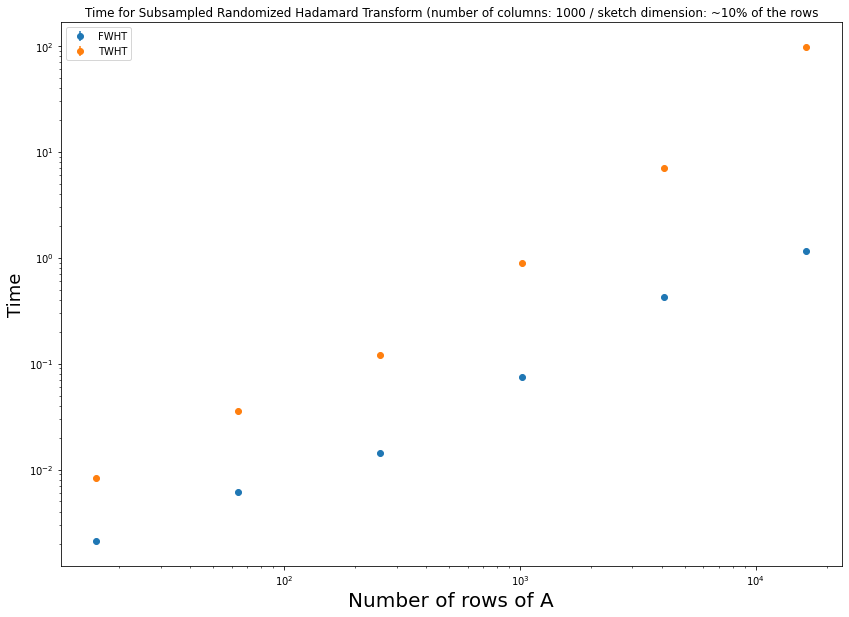

In [102]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(dims, avg_time_fwht, yerr=2*stdev_time_fwht, fmt='o', label="FWHT")
ax.errorbar(dims, avg_time_twht, yerr=2*stdev_time_twht, fmt='o', label="TWHT")

ax.set_xlabel("Number of rows of A", fontsize=20)
ax.set_ylabel("Time", fontsize=18)
ax.set_title("Time for Subsampled Randomized Hadamard Transform (number of columns: " + str(p) + " / sketch size: ~10% of the rows")
ax.legend()
plt.show()

### Sparse input matrix

In [103]:
np.random.seed(12345)

fwht_time_sparse = []
twht_time_sparse = []
dim_sparse = 2 ** np.arange(4, 16, 2)
p = 1000
for m in dim_sparse:
    # Computing PHA
    A = sparse.random(m, p, density=0.1, format="lil")

    sketch_size = int(0.1 * m) + 1 # ~10% of original size
    sample_indices = np.random.choice(m, sketch_size, replace=False)
    print("\nMatrix shape: ", (m, p))
    print("Sketch size: ", sketch_size)

    tmp1 = %timeit -n 1 -r 1 -o fwht_matrix(A)[sample_indices, :]
    tmp2 = %timeit -n 1 -r 1 -o trimmed_wht(A, sample_indices, sketch_size, p)
    fwht_time_sparse.append(tmp1)
    twht_time_sparse.append(tmp2)


avg_time_fwht_sparse = np.array([fwht_time_sparse[i].average for i in range(len(fwht_time_sparse))])
stdev_time_fwht_sparse = np.array([fwht_time_sparse[i].stdev for i in range(len(fwht_time_sparse))])

avg_time_twht_sparse = np.array([twht_time_sparse[i].average for i in range(len(twht_time_sparse))])
stdev_time_twht_sparse = np.array([twht_time_sparse[i].stdev for i in range(len(twht_time_sparse))])


Matrix dimension:  (16, 1000)
Sketch dimension:  2
205 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
23.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (64, 1000)
Sketch dimension:  7
945 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
72.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (256, 1000)
Sketch dimension:  26
5.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
432 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (1024, 1000)
Sketch dimension:  103
25.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (4096, 1000)
Sketch dimension:  410
1min 52s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Matrix dimension:  (16384, 1000)
Sketch dimension:  1639
8min 18s ± 0 ns per loop (me

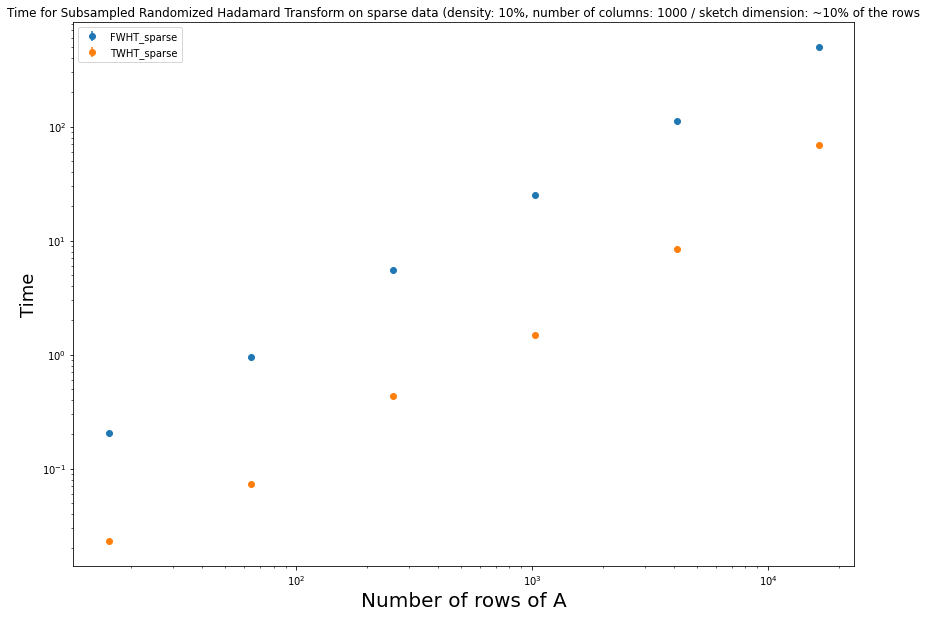

In [104]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(dim_sparse, avg_time_fwht_sparse, yerr=2*stdev_time_fwht_sparse, fmt='o', label="FWHT_sparse")
ax.errorbar(dim_sparse, avg_time_twht_sparse, yerr=2*stdev_time_twht_sparse, fmt='o', label="TWHT_sparse")

ax.set_xlabel("Number of rows of A", fontsize=20)
ax.set_ylabel("Time", fontsize=18)
ax.set_title("Time for Subsampled Randomized Hadamard Transform on sparse data (density: 10%, number of columns: " + str(p) + " / sketch size: ~10% of the rows")
ax.legend()
plt.show()

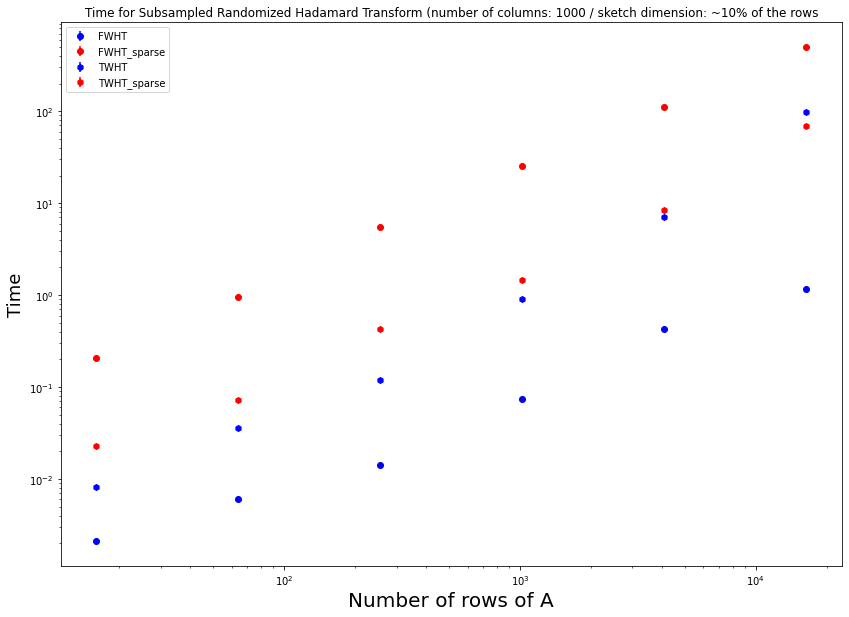

In [112]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(dims, avg_time_fwht, yerr=2*stdev_time_fwht, fmt="o", color="b", label="FWHT")
ax.errorbar(dim_sparse, avg_time_fwht_sparse, yerr=2*stdev_time_fwht_sparse, fmt="o", color="r", label="FWHT_sparse")
ax.errorbar(dims, avg_time_twht, yerr=2*stdev_time_twht, fmt="H", color="b", label="TWHT")
ax.errorbar(dim_sparse, avg_time_twht_sparse, yerr=2*stdev_time_twht_sparse, fmt="H", color="r", label="TWHT_sparse")

ax.set_xlabel("Number of rows of A", fontsize=20)
ax.set_ylabel("Time", fontsize=18)
ax.set_title("Time for Subsampled Randomized Hadamard Transform (number of columns: " + str(p) + " / sketch size: ~10% of the rows")
ax.legend()
plt.show()

## Computing D * A where D is a random diagonal Rademacher matrix

In [ ]:
# Computing D * A
# m = 2 ** 2
# A = np.random.randint(5, size=(m, m))
# A
# diag = np.random.choice([1, -1], size=m) # 1st source of randomness
# diag
# (A.T * diag).T